In [1]:
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
import glob
import pandas as pd
import numpy as np

import sys
sys.path.insert(0, '/home/misa/git_repositories/APDFT/prototyping/atomic_energies')
import explore_qml_data as eqd

### Define smiles strings for selected molecules

In [2]:
# get smiles string for structure -> make canonical

# benzene derivates
benzene_derivates = ['Cc1ccccc1', 'Nc1ccccc1', 'Oc1ccccc1']

# cyclohexane derivatives
cyclohexane_derivates = ['CC1CCCCC1', 'OC1CCCCC1']

# conjugated vs saturated
#conj_sat = ['C=C/C=C/C', 'C=C/C=C/N', 'C=C/C=C/O'] # , 'CCCCC', 'CCCCN', 'CCCCO'

# change in number of electrons
changing_Ne = ['C', 'CC', 'CCC', 'CCCC', 'CCCCC', 'CCCCCC']

### Make database with all canonical smiles strings

In [3]:
# get smiles strings for all molecules in qm9 -> make canonical
files = glob.glob('/home/misa/datasets/qm9/dsgdb9nsd_*')
files.sort()
data = pd.DataFrame(index=np.arange(len(files)), columns=['name', 'smiles canonical', 'path'])

In [4]:
canonical_smiles = []
names = []
for i, f in enumerate(files):
    # get smiles
    if i in 13388*np.arange(0, 9):
        print(i)
    smiles = eqd.get_smiles(f)
    canonical_smiles.append(Chem.MolToSmiles(Chem.MolFromSmiles(smiles)))
#     if smiles != Chem.MolToSmiles(Chem.MolFromSmiles(smiles)):
#         print(f)
    #get name
    names.append(f.split('/')[-1].split('.')[0])

0
13388
26776
40164
53552
66940
80328
93716
107104


In [5]:
data['name'] = names
data['smiles canonical'] = canonical_smiles
data['path'] = files

### Find path to smiles in database

In [6]:
molecule_paths = []
# benzene
for mol in benzene_derivates:
    canonical_smile = Chem.MolToSmiles(Chem.MolFromSmiles(mol))
    molecule_paths.append(data.loc[data['smiles canonical'] == canonical_smile, 'path'].item())
    
for mol in cyclohexane_derivates:
    canonical_smile = Chem.MolToSmiles(Chem.MolFromSmiles(mol))
    molecule_paths.append(data.loc[data['smiles canonical'] == canonical_smile, 'path'].item())
    
# for mol in conj_sat:
#     canonical_smile = Chem.MolToSmiles(Chem.MolFromSmiles(mol)).capitalize()
#     molecule_paths.append(data.loc[data['smiles canonical'] == canonical_smile, 'path'].item())
    
for mol in changing_Ne:
    canonical_smile = Chem.MolToSmiles(Chem.MolFromSmiles(mol))
    molecule_paths.append(data.loc[data['smiles canonical'] == canonical_smile, 'path'].item())

In [7]:
molecule_paths

['/home/misa/datasets/qm9/dsgdb9nsd_000930.xyz',
 '/home/misa/datasets/qm9/dsgdb9nsd_000940.xyz',
 '/home/misa/datasets/qm9/dsgdb9nsd_000949.xyz',
 '/home/misa/datasets/qm9/dsgdb9nsd_002102.xyz',
 '/home/misa/datasets/qm9/dsgdb9nsd_002110.xyz',
 '/home/misa/datasets/qm9/dsgdb9nsd_000001.xyz',
 '/home/misa/datasets/qm9/dsgdb9nsd_000007.xyz',
 '/home/misa/datasets/qm9/dsgdb9nsd_000013.xyz',
 '/home/misa/datasets/qm9/dsgdb9nsd_000039.xyz',
 '/home/misa/datasets/qm9/dsgdb9nsd_000133.xyz',
 '/home/misa/datasets/qm9/dsgdb9nsd_000543.xyz']

In [8]:
mols_selected = []
for m in molecule_paths:
    s = eqd.get_smiles(m)
    mols_selected.append(Chem.MolFromSmiles(s))

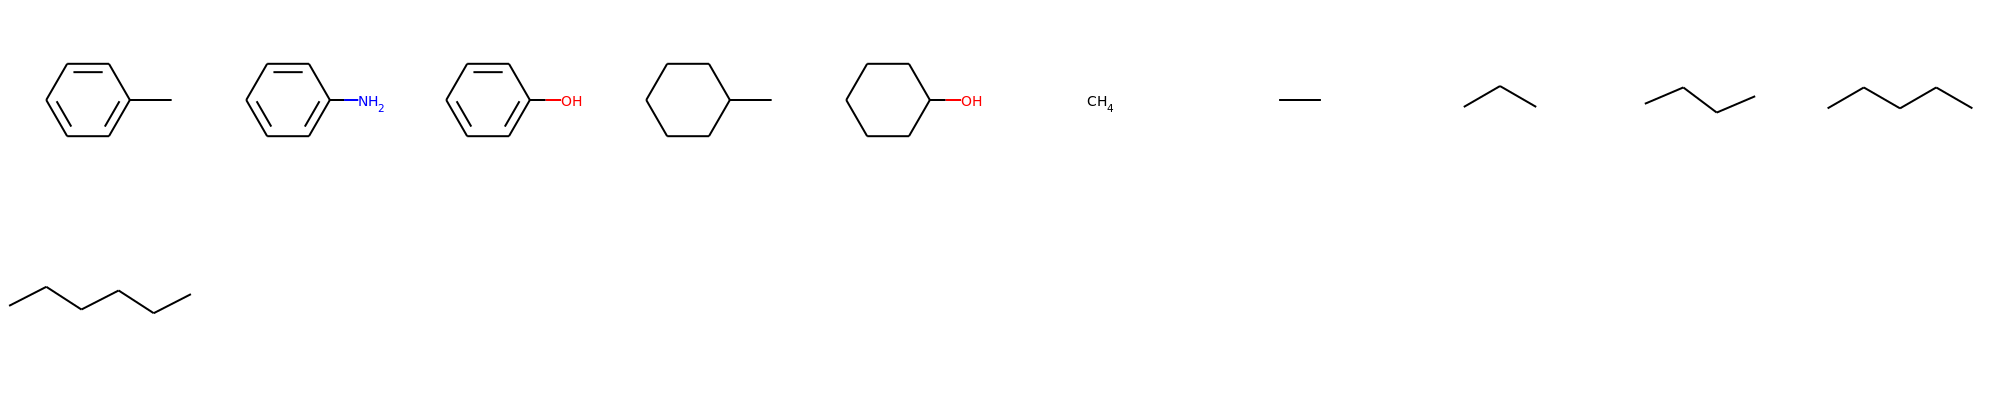

In [9]:
Chem.Draw.MolsToGridImage(mols_selected,molsPerRow=10,subImgSize=(200,200), maxMols=1000)    

In [ ]:
smiles = []
with open('/home/misa/datasets/qm9/correct_smiles.txt') as f:
    for line in f:
        smiles.append(line.split()[0])

In [ ]:
c5 = []
for s in smiles:
    upper = s.upper()
    if upper.count('C') == 5 and not 'O' in upper and not 'N' in upper and not 'F' in upper:
        c5.append(s)

In [ ]:
c5